# Weather Impact on Agricultural Commodity Prices

Importing necessary libraries:

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv

Add root directory to PATH:

In [2]:
module_path = Path().cwd().parent.as_posix()
if module_path not in sys.path:
    sys.path.append(module_path)

Importing custom functions and modules:

In [3]:
from src.price import get_commodity_data
from src.noaa import noaa_batch_data_extraction
from src.nasa import nasa_batch_data_extraction
from src.utils import load_price, data_prep
from src.data_prep import preprocess_data, save_cleaned_data
from src.data_viz import plot_time_series, plot_spectral_analysis, plot_ecm_adjustment
from src.analysis import test_stationarity, fit_arima_model, error_correction_model, regression_model, create_regression_table, rolling_window_validation

Autoreload on update:

In [4]:
%load_ext autoreload
%autoreload 2

Load environment variables from .env file:

In [5]:
load_dotenv(override=True)

True

Define and create (if not exists) data folder:

In [6]:
DATA_FOLDER = Path().cwd().parent / 'data'
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

Define research time span:

In [7]:
START, END = "2010-01-01", "2025-01-01"

## Step 4: Exploratory Data Analysis

Let's perform EDA for the first set of commodities along with corresponding weather data (NASA POWER data are used as they are more reliable):
- commodity: `Dairy/Milk`
- refined product: `Butter`
- tickers: `DC=F`, `CB=F`
- main production states: `Wisconsin`, `California`, `New York` 	`
- weather data privider: `NASA POWER`

In [19]:
# Load tickers dictionary.
with open(Path.cwd().parent / 'lib' / 'tickers.json', 'r') as fp:
    TICKERS = json.load( fp)

# Define states.
states = ['Wisconsin', 'California', 'New_York']

# Load and concatenate data.
dairy_data = data_prep(
    comoddities=list(TICKERS.keys())[-2:],
    states=states,
    tickers_dict=TICKERS,
    data_folder=DATA_FOLDER,
    data_provider='nasa'
).set_index('date')

dairy_data.index = pd.to_datetime(dairy_data.index)

Just for the sake of simplicity in using already prepared functions we are gonna rename columns as follows:
> dairy/milk -> dairy<br>
> butter -> dairy_oil

In [20]:
dairy_data = dairy_data.rename(columns={'dairy/milk': 'dairy', 'butter': 'dairy_oil'})

Preprocessing data by removing ouliers and filling missing values:

In [21]:
cleaned_df, metadata = preprocess_data(df=dairy_data, states=list(map(str.lower, states)), commodity='dairy')

Starting data preprocessing...
Missing values summary:
  dairy: 1.27% missing
  dairy_oil: 1.46% missing
  wisconsin_tmin: 0.00% missing
  wisconsin_tmax: 0.00% missing
  wisconsin_prc: 0.00% missing
  california_tmax: 0.00% missing
  california_tmin: 0.00% missing
  california_prc: 0.00% missing
  new_york_tmin: 0.00% missing
  new_york_tmax: 0.00% missing
  new_york_prc: 0.00% missing
Processing column: dairy
Winsorized 4 outliers in dairy
Processing column: dairy_oil
Winsorized 4 outliers in dairy_oil
Processing column: wisconsin_tmin
Winsorized 1 outliers in wisconsin_tmin
Processing column: wisconsin_tmax
Winsorized 5 outliers in wisconsin_tmax
Processing column: wisconsin_prc
Winsorized 116 outliers in wisconsin_prc
Processing column: california_tmax
Winsorized 2 outliers in california_tmax
Processing column: california_tmin
Winsorized 0 outliers in california_tmin
Processing column: california_prc
Winsorized 131 outliers in california_prc
Processing column: new_york_tmin
Winsori

Saving data:

In [22]:
save_cleaned_data(cleaned_df, metadata, DATA_FOLDER / 'analysis' / 'cleaned', 'dairy')

Saved cleaned data to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/cleaned/dairy_weather_cleaned.parquet
Saved metadata saved to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/cleaned/dairy_weather_cleaned_metadata.json


First, let's look at commodity price spread depending on the waether anomalies:

Saved time series plot to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/results/time_series_dairy_spread_california_temp_anomaly_30d.png


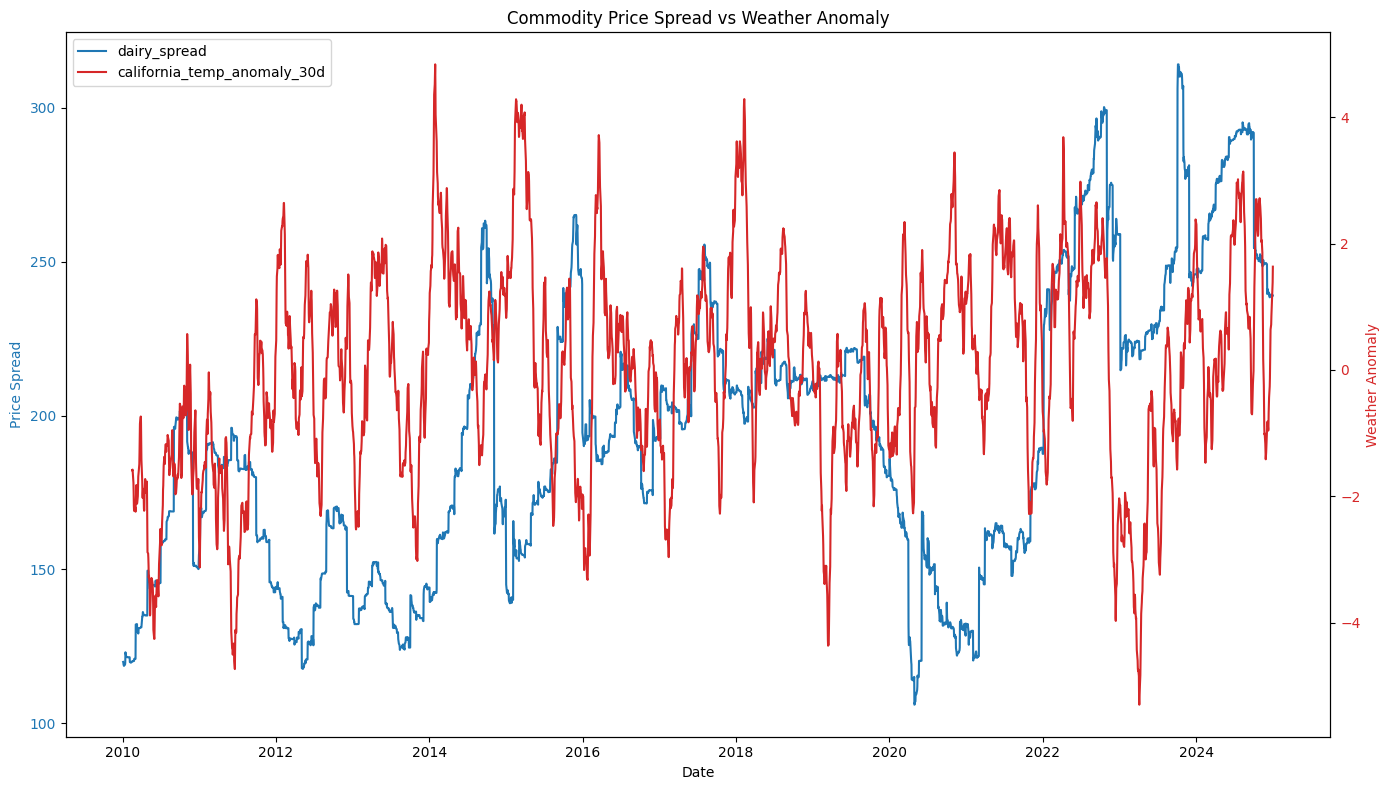

In [27]:
plot_time_series(df=cleaned_df, data_folder=DATA_FOLDER / 'analysis' / 'results', spread_col='dairy_spread', anomaly_col='california_temp_anomaly_30d')

Now let's plot spectral analysis for dairy data as well:

Saved spectral analysis plot to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/results/spectral_analysis_dairy_spread.png


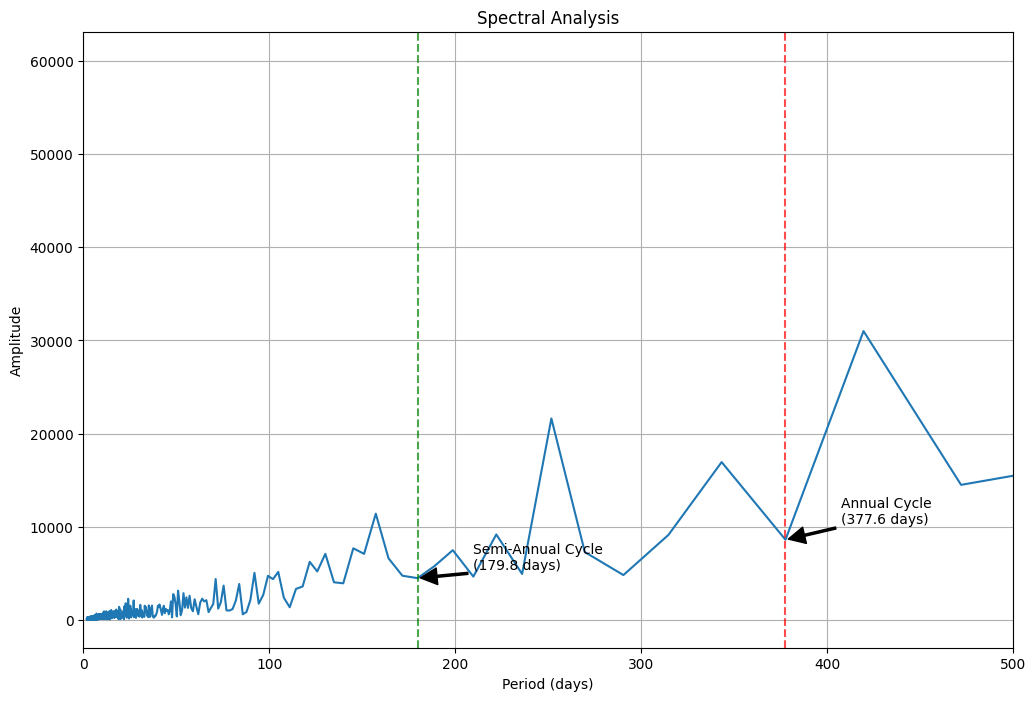

Top 5 dominant periods for dairy_spread: [1258.66666667  251.73333333  419.55555556  944.         1888.        ] days


In [28]:
dominant_periods = plot_spectral_analysis(cleaned_df, data_folder=DATA_FOLDER / 'analysis' / 'results', column='dairy_spread')

Dairy-butter spread also shows oscilations around six‐month and twelve‐month cycles however the structure differs from corn and soybeans - peaks a less spreaded.

## Step 5: Time Series Analysis

First of all we check time series stationarity wuth Augmented Dickey-Fuller test:

In [29]:
for col in ['dairy', 'dairy_oil', 'dairy_spread']:
    if col in cleaned_df.columns:
        print(f"\nStationarity Test for {col}:")
        test_stationarity(cleaned_df[col])


Stationarity Test for dairy:
ADF Statistic: -3.7977
p-value: 0.0029
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is stationary (p-value <= 0.05)

Stationarity Test for dairy_oil:
ADF Statistic: -3.0912
p-value: 0.0272
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is stationary (p-value <= 0.05)

Stationarity Test for dairy_spread:
ADF Statistic: -2.4938
p-value: 0.1170
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)


We can see the stationarity for original price time series, however the spred is still non-stationary.

Then apply ARIMA model for corn data:

In [30]:
# Fit ARIMA model for corn spread.
if 'dairy_spread' in cleaned_df.columns:
    arima_model = fit_arima_model(cleaned_df['dairy_spread'])

ADF Statistic: -2.4938
p-value: 0.1170
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)
Series is not stationary, differencing will be applied
Best ARIMA order: (0, 1, 1) with AIC: 19967.2848
ARIMA Model Summary for dairy_spread:
                               SARIMAX Results                                
Dep. Variable:           dairy_spread   No. Observations:                 3776
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -9981.642
Date:                Wed, 21 May 2025   AIC                          19967.285
Time:                        01:26:09   BIC                          19979.757
Sample:                             0   HQIC                         19971.719
                               - 3776                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

Now let's perform cointegration analysis:


Cointegration Analysis for Dairy and Butter:
Johansen Cointegration Test for ['dairy', 'dairy_oil']:
Trace Statistics:
 [21.65780832  5.94890363]
Critical Values (5%): [15.4943  3.8415]
Cointegration Rank: 2

Vector Error Correction Model (VAR on diffs) Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, May, 2025
Time:                     01:26:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.227711
Nobs:                     3774.00    HQIC:                  0.221322
Log likelihood:          -11115.1    FPE:                    1.24334
AIC:                     0.217797    Det(Omega_mle):         1.24136
--------------------------------------------------------------------
Results for equation dairy
                  coefficient       std. error           t-stat            prob
----------------------------------------

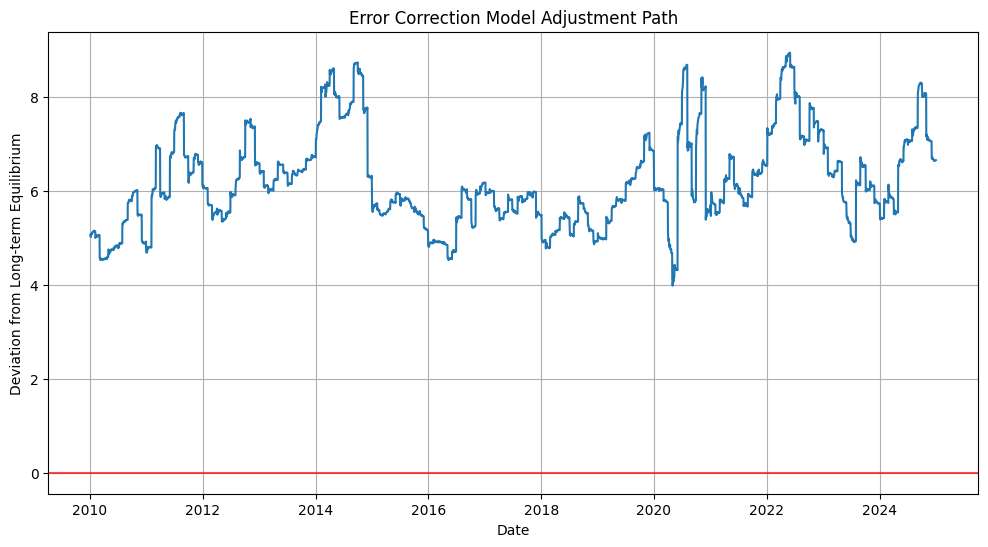

In [31]:
# Cointegration and error correction model
if all(col in cleaned_df.columns for col in ['dairy', 'dairy_oil']):
    print("\nCointegration Analysis for Dairy and Butter:")
    var_results, ec_series = error_correction_model(cleaned_df, ['dairy', 'dairy_oil'])

    if ec_series is not None:
        plot_ecm_adjustment(cleaned_df, DATA_FOLDER / 'analysis' / 'results', ec_series, commodity='dairy')

The ECM results for milk and butter prices analysis shows a stable long run cointegrating relationship with the error correction term being consistently positive. This suggests a durable long-term pricing spread (premium) between milk and butter, perhaps associated with fundamentally based margins or processing spreads. The deviation series displays mean-reverting behaviors toward the non-zero equilibrium level, indicating that the ECM approach is appropriate to model this dairy product pair.

## Step 6: Regression Analysis

Let's perform regression analysis:

After searching for best set of independatn variables to fit to the model we come to a conclusion that:
1) 'wisconsin_temp_anomaly_30d', 'wisconsin_prc_anomaly_30d', 'california_temp_anomaly_30d', 'california_prc_anomaly_30d' - show the most impact on target variable while being statistically significant;
2) weather conditions in the states under consideration, have significantly lowwe impact on dairy prices than in the soybeans case? but a little higher than in case of corn - around 4% of variance described by weather anomalies.

In [34]:
# Regression analysis with weather variables.
if 'dairy_spread' in cleaned_df.columns:
    # Define weather variables.
    # weather_vars = [col for col in cleaned_df.columns if 'anomaly' in col]
    weather_vars = ['wisconsin_temp_anomaly_30d', 'wisconsin_prc_anomaly_30d', 'california_temp_anomaly_30d', 'california_prc_anomaly_30d']

    if weather_vars:
        print("\nRegression Analysis of Price Spread vs Weather Anomalies:")
        reg_results, coef_df = regression_model(cleaned_df, 'dairy_spread', weather_vars, lags=0)
        create_regression_table(reg_results, DATA_FOLDER / 'analysis' / 'results', filename='dairy_regression_results.csv')

        # Validation.
        print("\nPerforming Rolling Window Validation:")
        validation_df, avg_metrics = rolling_window_validation(cleaned_df, DATA_FOLDER / 'analysis' / 'results', 'dairy_spread', weather_vars, filename='dairy_validation_results.csv')


Regression Analysis of Price Spread vs Weather Anomalies:
Regression Model for dairy_spread:
                            OLS Regression Results                            
Dep. Variable:           dairy_spread   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     39.02
Date:                Wed, 21 May 2025   Prob (F-statistic):           4.77e-32
Time:                        01:32:40   Log-Likelihood:                -19595.
No. Observations:                3747   AIC:                         3.920e+04
Df Residuals:                    3742   BIC:                         3.923e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------